# 0. Google Colab Related
This part of code is for Google Colabs setups, please ignore these cells if you run the notebook locally.

In [1]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# os.chdir('./drive/MyDrive/cmpt419 affective computing hw3')

In [3]:
# os.listdir()

In [4]:
# !unzip 'fer2013.zip'

In [5]:
# !unzip -d './phoebe' 'Phoebe.zip'

# 1. Data Loading and Exploration

In [6]:
# !pip install keras-tuner

In [7]:
import os

import numpy as np
import pandas as pd

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

import tensorflow as tf
import keras
from tensorflow.keras import models, layers, regularizers, callbacks, optimizers
import keras_tuner

In [8]:
COLAB = False # please set it to False if you run locally

if COLAB:
  FER_PATH = "fer2013.csv"
  PHOEBE_PATH = "./phoebe/Phoebe/phoebe_AU.csv"
  IMGS_PATH = "./phoebe/Phoebe/images"
else:
  FER_PATH = "fer2013.csv"
  PHOEBE_PATH = "phoebe_AU.csv"
  IMGS_PATH = "./images"

## 1.1 Load Fer2013

In [9]:
fer_df = pd.read_csv(FER_PATH)
fer_df.head(3)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training


In [10]:
# show the numebr of dimension of fer imagesf
fer_dim = len(fer_df['pixels'][0].split(' '))
print("fer images num dimension: ", fer_dim)

fer images num dimension:  2304


In [11]:
# reshape one fer image displaying
def reshape_and_show(img_data, label):
	image_reshaped = np.reshape(img_data, (48, 48))

	# Display the image
	plt.imshow(image_reshaped, cmap='gray')  # cmap='gray' for grayscale images
	plt.title(f'Emotion: {label}')
	plt.axis('off')  # Turn off axis
	plt.show()

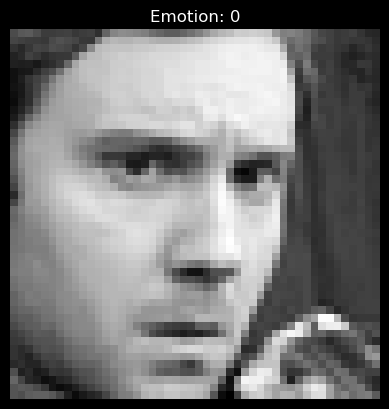

In [12]:
img_data = fer_df['pixels'][0].split(' ')
img_data = [int(i) for i in img_data]
label = fer_df['emotion'][0]

reshape_and_show(img_data, label)

In [13]:
# the number of different kinds of emotion
fer_df['emotion'].nunique()

7

In [14]:
# the number of images for each class -> Class 1 is a minority class
fer_df['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

## 1.2 Load Phoebe AU

In [15]:
phoebe_df = pd.read_csv(PHOEBE_PATH)
phoebe_df.head(3)

,file_name,confidence,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU45_c,label
0,1_01.jpg,0.98,0.76,0.96,0.22,0.00,0.00,0.35,0.0,0.16,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,unknown
1,2_41.jpg,0.98,0.03,0.00,1.59,0.00,0.18,0.70,0.1,0.80,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
2,2_01.jpg,0.98,0.40,0.61,0.63,0.05,0.00,0.00,0.0,0.85,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,surprise


In [16]:
print(len(phoebe_df))

98


## 1.3 Load Phoebe Images

In [17]:
efile_names = os.listdir(IMGS_PATH)
# map the file name to the file path for furture usage
img_dic = {}
for emo in efile_names:
	if not emo.endswith('DS_Store'):
		efile_path = IMGS_PATH + "/{}".format(emo)
		file_names = os.listdir(efile_path)
		for f in file_names:
			if not f.endswith('DS_Store'):
				img_dic[f] = efile_path + '/{}'.format(f)

print(img_dic['1_01.jpg'])

./images/unknown/1_01.jpg


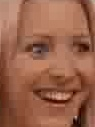

In [18]:
Image(filename=img_dic['10_51.jpg'])

In [19]:
# check the dimension of the images -> not in uniform size
dims = []
for f, p in img_dic.items():
	image = cv2.imread(p)
	height, width, _ = image.shape
	dims.append((height, width))

print(set(dims))

{(132, 94), (189, 146), (155, 126), (138, 110), (158, 122), (100, 74), (162, 122), (126, 92), (126, 101), (155, 119), (100, 76), (117, 92), (128, 92), (111, 85), (124, 97), (103, 74), (144, 109), (121, 89), (140, 102), (113, 85), (94, 71), (128, 103), (98, 71), (81, 64), (126, 96), (127, 95), (89, 65), (132, 100), (145, 103), (119, 93), (120, 92), (124, 92), (133, 104), (121, 93), (136, 93), (125, 93), (133, 106), (135, 103), (153, 118), (196, 153), (130, 98), (114, 92), (117, 91), (92, 71), (137, 103), (126, 93), (118, 89), (129, 104), (121, 100), (92, 73), (96, 73), (141, 105), (147, 118), (107, 82), (156, 130), (118, 91), (134, 109), (129, 97), (193, 142), (114, 87), (138, 109), (158, 121), (132, 102), (137, 98), (105, 78), (133, 94), (107, 75), (134, 102), (129, 99), (131, 96), (110, 85), (124, 93), (98, 74), (125, 92), (173, 141), (196, 152), (121, 88), (110, 87), (147, 115), (114, 84), (129, 103), (132, 99), (149, 115), (119, 92), (105, 75), (88, 68), (133, 100), (125, 96), (129,

# 2. Part A - Support Vector Machine
In this part, I use Support Vector Machine(SVM) to perform facial emotion classification task.

## 2.1 SVM for fer2013
+ Here I did not perform a thorough hyperparameter tunning on the SVM model beacuse I am using my own machine, which takes about 25 minuntes to train one model. Following are the reason why I tune these two parameters: (1) **kernel**: The classification task here is to classify images, so there is little chance that the decision surface is linear, so I chose three different non-linear kernels. (2) **C**: C is the square l2 penalty regularization parameter, the strength of the regularization is inversely proportional to C. Here I only chose two values of C, usually more values needs to be experimented.
---
+ **result analysis**: (1)SVM model trained on fer tends to classify non-happy images as happy images. (2) Though class 1(disgust) is a minor class with only 500 data points, SVM does a good job detect disgust faces, this can be explained as its ability of dealing with biased dataset.
---
+ *The fer2013-SVM model tested on Pheobe unknown images is in the bottom of the notebook after Part C!*

In [20]:
# construct training, validation and test sets
fer_train_df = fer_df[fer_df['Usage'] == 'Training']
fer_val_df = fer_df[fer_df['Usage'] == 'PublicTest']
fer_test_df = fer_df[fer_df['Usage'] == 'PrivateTest']

columns_to_drop = ['emotion', 'Usage']
fer_train_Y = fer_train_df['emotion']
fer_train_X = fer_train_df.drop(columns=columns_to_drop)

fer_val_Y = fer_val_df['emotion']
fer_val_X = fer_val_df.drop(columns=columns_to_drop)

fer_test_Y = fer_test_df['emotion']
fer_test_X = fer_test_df.drop(columns=columns_to_drop)

In [21]:
# parse the pixel to seperate columns and normalize each feature
def pre_process(X):
	X = X['pixels'].str.split(expand = True)
	scaler = StandardScaler()
	X = pd.DataFrame(scaler.fit_transform(X))
	return X

fer_train_X = pre_process(fer_train_X)
fer_val_X = pre_process(fer_val_X)
fer_test_X = pre_process(fer_test_X)

In [22]:
# hyperparameter tunning
kernels = ['poly', 'rbf', 'sigmoid']
C = [0.1, 1.0]
fer_svms = {}
for k in kernels:
	for c in C:
		fer_svm = SVC(C=c, kernel=k)
		fer_svm.fit(fer_train_X, fer_train_Y)
		pred_val = fer_svm.predict(fer_val_X)
		pred_test = fer_svm.predict(fer_test_X)
		fer_svms[k + '-{}'.format(c)] = (fer_svm, pred_val, pred_test)

In [23]:
# validation accuracy comparisom
def val_eval(model_dic, val_y):
	f1_dic = {}
	for k, v in model_dic.items():
		model, val_pred, test_pred = v
		f1_dic[k] = f1_score(val_pred, val_y, average='micro')

	model_names = list(f1_dic.keys())
	scores = list(f1_dic.values())

	# Plotting
	plt.figure(figsize=(10, 8))
	plt.plot(model_names, scores, marker='o', linestyle='-')
	plt.xlabel('Model Type')
	plt.ylabel('F1 Score')
	plt.title('Validation F1 scores')
	plt.xticks(rotation=45)
	plt.grid(True)
	plt.tight_layout()
	plt.show()

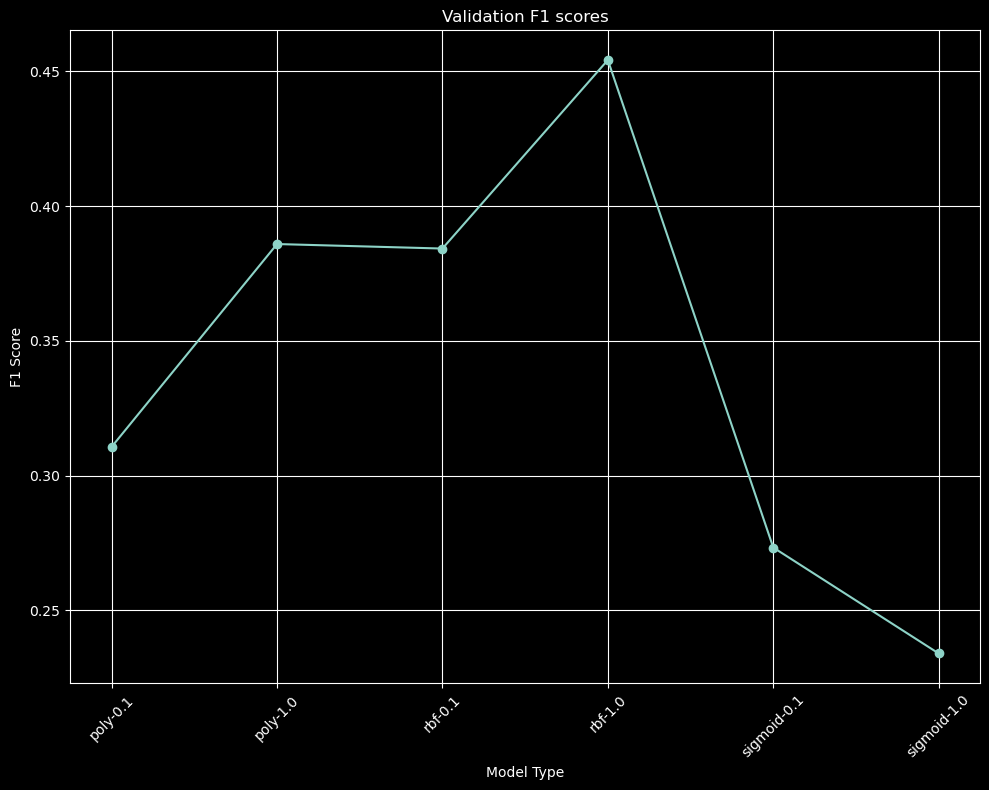

In [24]:
val_eval(fer_svms, fer_val_Y)

In [25]:
# evaluate the best model performance on the test set
def eval(pred, gt_y, labels):
	print("Accuracy: {0:.2f}".format(accuracy_score(pred, gt_y)))
	print("F-score: {0:.2f}".format(f1_score(pred, gt_y,average='macro')))
	print("Precision: {:.2f}".format(precision_score(pred, gt_y, average='macro')))
	print("Recall: {:.2f}".format(recall_score(pred, gt_y, average='macro')))
	cm = confusion_matrix(gt_y, pred, labels = labels)

	# visualize the confusion matrix
	plt.figure(figsize=(10, 8))
	sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels= labels, yticklabels=labels)
	plt.xlabel('Predicted labels')
	plt.ylabel('True labels')
	plt.title('Confusion Matrix')
	plt.show()

Accuracy: 0.45
F-score: 0.38
Precision: 0.38
Recall: 0.53


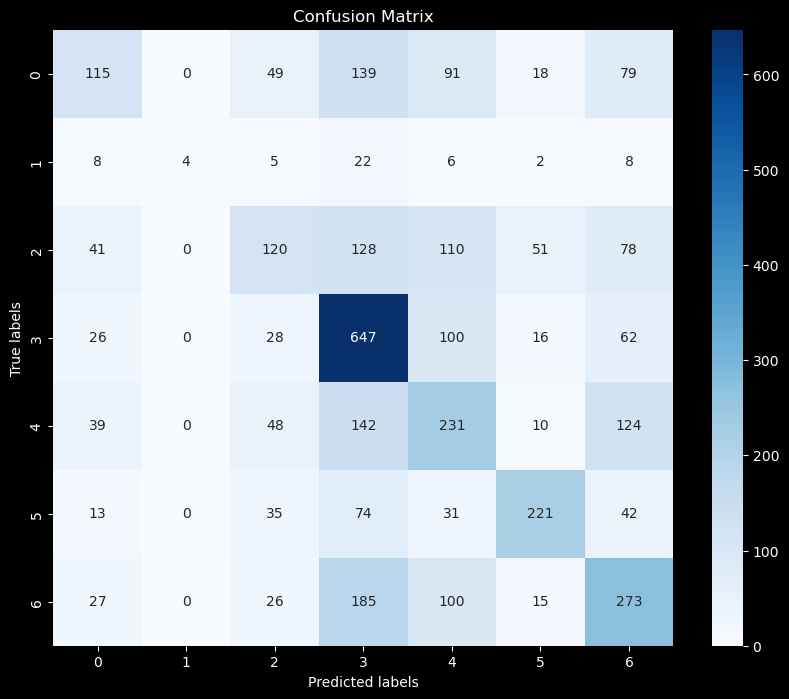

In [26]:
eval(fer_svms['rbf-1.0'][2], fer_test_Y, [0,1,2,3,4,5,6])

## 2.2 SVM for Phoebe
+ This part of codes are written in reference to sci-kit learn offical site: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
+ If we use the criteria of 8:2 as class imbalance, then in Phoebe dataset, the largest difference class number is happy(33) and disgust(9), which has a ratio of 3.67 : 1. Thus here I treat this dataset as a **balance dataset**.
+ Since unknown folder contains images with no labels, I give each image with a label.
---
+ **result analysis**: SVM gives an average performance on this dataset, it also tends to classify non-happy images as happy images.

In [119]:
phoebe_known_df = phoebe_df[phoebe_df['label'] != 'unknown']
phoebe_unknown_df = phoebe_df[phoebe_df['label'] == 'unknown']

In [120]:
# construct Phoebe AU training, validation, test sets
columns_to_drop = ['file_name', ' confidence', 'label']
Phoebe_train_X = phoebe_known_df.drop(columns_to_drop, axis = 1)
Phoebe_train_Y = phoebe_known_df['label']
Phoebe_train_X = pd.DataFrame(StandardScaler().fit_transform(Phoebe_train_X))

Phoebe_test_X = phoebe_unknown_df.drop(columns_to_drop, axis = 1)
Phoebe_test_Y = pd.DataFrame({'label' : ['angry', 'angry', 'sad', 'happy', 'surprise', 'angry', 'surprise', 'happy', 'sad', 'happy', 'disgust', 'surprise']})
Phoebe_test_X = pd.DataFrame(StandardScaler().fit_transform(Phoebe_test_X))

In [121]:
# check test set data distribution
Phoebe_test_Y.value_counts()

label   
angry       3
happy       3
surprise    3
sad         2
disgust     1
dtype: int64

In [122]:
# perform 5-fold corss validation for hyper parameter tunning
skf = StratifiedKFold(n_splits= 5)
# store each fold's results
f1_scores = {}
acc_scores = {}
# hyperparameters
kernels = ['rbf', 'sigmoid', 'poly']
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
for kn in kernels:
	for c in C:
		accscores = []
		f1scores = []
		for k, (train_x_index, test_x_index) in enumerate(skf.split(Phoebe_train_X, Phoebe_train_Y)):
			train_x = Phoebe_train_X.iloc[train_x_index]
			train_y = Phoebe_train_Y.iloc[train_x_index]
			test_x = Phoebe_train_X.iloc[test_x_index]
			test_y = Phoebe_train_Y.iloc[test_x_index]

			# train and inference of current model
			pb_svm = SVC(C=c, kernel=kn)
			pb_svm.fit(train_x, train_y)
			pred_test = pb_svm.predict(test_x)

			# evaluate the model based on accuracy and macro f1
			acc = accuracy_score(pred_test, test_y)
			f1 = f1_score(pred_test, test_y, average = 'macro')
			f1scores.append(f1)
			accscores.append(acc)
		f1_scores["{}-{}".format(kn, c)] = np.mean(f1scores)
		acc_scores["{}-{}".format(kn, c)] = np.mean(accscores)


In [123]:
# pick the best hyperparameters
def val_eval2(f1_dic, name):

	model_names = list(f1_dic.keys())
	scores = list(f1_dic.values())

	# Plotting
	plt.figure(figsize=(10, 8))
	plt.plot(model_names, scores, marker='o', linestyle='-')
	plt.xlabel('Model Type')
	plt.ylabel('F1 Score')
	plt.title('Average 5-fold Validation {} scores'.format(name))
	plt.xticks(rotation=45)
	plt.grid(True)
	plt.tight_layout()
	plt.show()

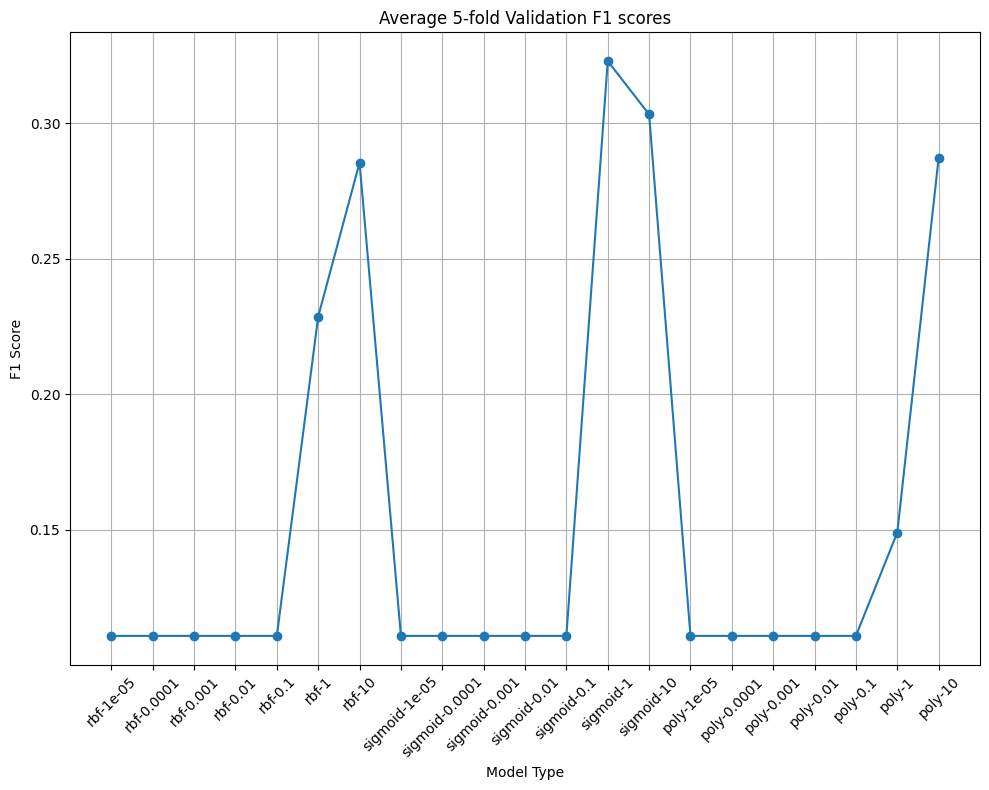

In [124]:
val_eval2(f1_dic= f1_scores, name = 'F1')

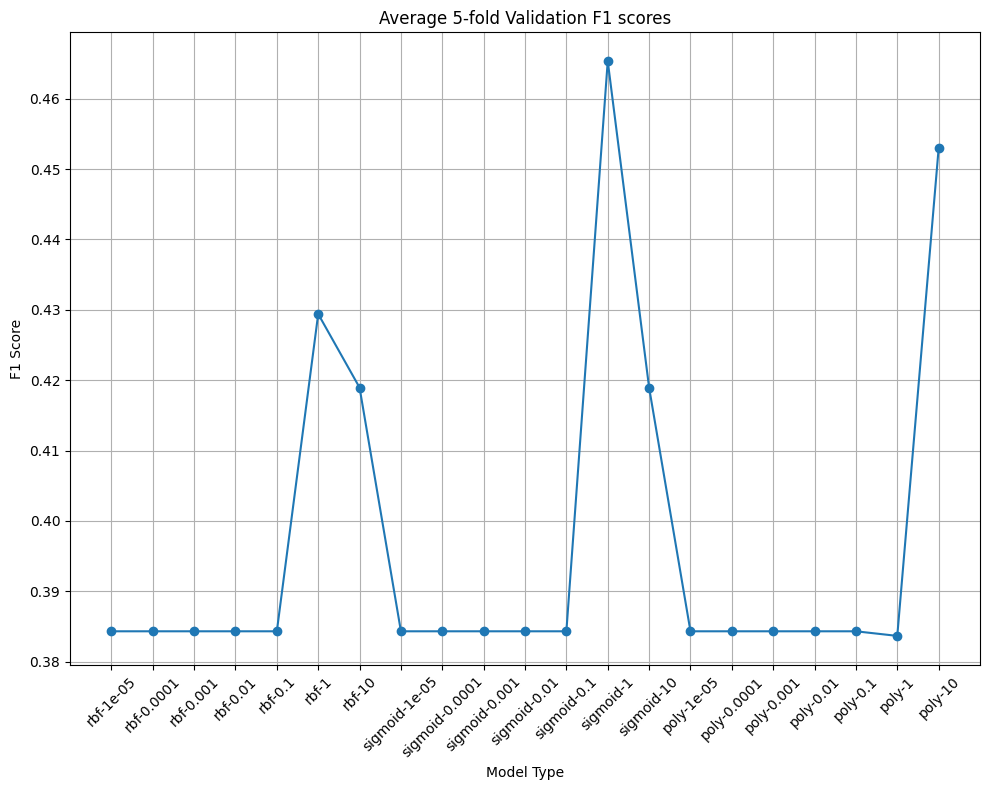

In [125]:
val_eval2(acc_scores, name = 'Accuracy')

In [126]:
# use the best hyperparameters to train the model on the whole training set
pb_svm = SVC(kernel= 'sigmoid', C = 1)

pb_svm.fit(Phoebe_train_X, Phoebe_train_Y)
pb_pred_test = pb_svm.predict(Phoebe_test_X)

Accuracy: 0.58
F-score: 0.46
Precision: 0.50
Recall: 0.45


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


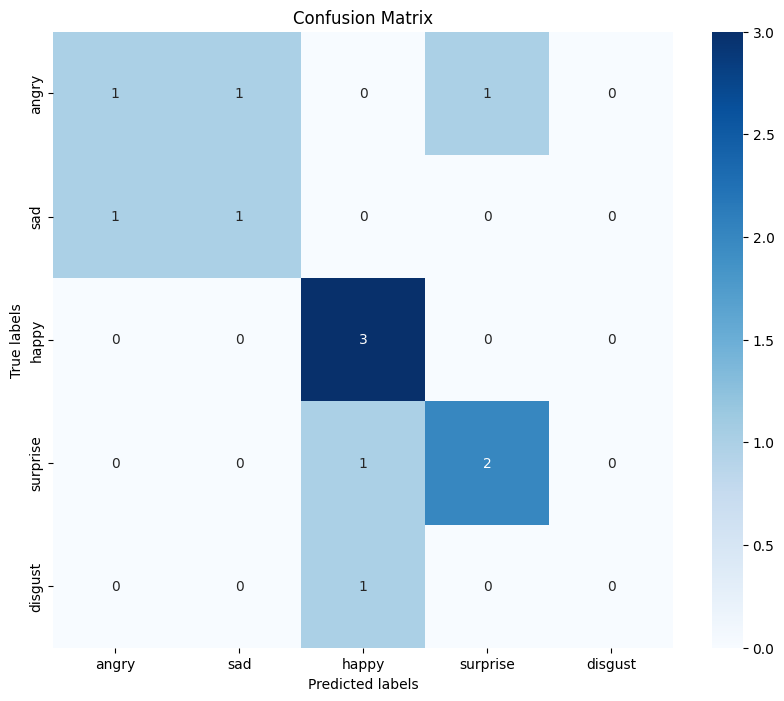

In [127]:
#evaluate the inference result
eval(pd.DataFrame(pb_pred_test), Phoebe_test_Y, Phoebe_test_Y['label'].unique())

# 3. Part B - Neural Network
In this part I construct Convolutional Neural Network(CNN) to perform the same facial emotion classification task as Part A.

## 3.1 fer2013 Neural Netwok
+ **Model Archietecture:** I chose to use a vgg-like sturcture, which constructed of a stacks of convolutional layer with batch normalization and maxpooling layer. vgg series is a calssic deep convolutional network that is used to perform vision-related tasks. I did not set the depth to be too deep considering the complexity of our task, and the time for training.
+ **Activation Function:** Chose ReLu as the activation function since Resnet also use ReLu
+ **Loss Function:** Since the task is a multiclass classification task, I chose to the family of corss entropy loss. For specifically, our ground truth lables are already provided in an integer form, I chose to use the sparse categorical crossentropy loss. Refer to the official document of Keras: https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class
+ **Optimizer:** I chose Adam as the optimzer for its adaptive learning rate and its robustness to different types of data and different kinds of works.
+ **hyperparameter tunning:** I use keras-tunner in search of the best sets of drop-out rate, learning rate, and batch size. As for the number of epoch to train, I use early stopping to prevent overfitting.
----
+ **result analysis**: (1)Compared to SVM performance of 45% accuracy and 38% F1 score on fer2013 dataset, CNN model has a much better performance of 60% accuracy and 57% F1 score. This could due to CNN's convolutional design that can specifically deal with image-based data feature extraction, the strides used can extract multi-pixel-level details of the image. But SVM does not have similar capability, thus it may get lost in the huge flattened features and hard to learn the descision plane from them. (2) From the confusion matrix generated, CNN model is having a hard time differentiate sad face and neutrual faces.

In [32]:
# reshape fer2013 data for cnn
fer_train_reshape_X = fer_train_X.values.reshape(-1, 48, 48, 1)
fer_val_reshape_X = fer_val_X.values.reshape(-1, 48, 48, 1)
fer_test_reshape_X = fer_test_X.values.reshape(-1, 48, 48, 1)

In [33]:
# Colab GPU settings
# if COLAB:
tf.config.list_physical_devices('GPU')
os.environ["CUDA_VISABLE_DEVICES"] = "0"

In [34]:
'''
    Model Architecture Construction
    The keras-tuner utilization code is written in reference to
    1. the offical documentation: https://keras.io/guides/keras_tuner/getting_started/,
    2. a Youtube tutorial: https://www.youtube.com/watch?v=Clo1HKB50Ug,
    3. The Keras-tuner issue log: https://github.com/keras-team/keras-tuner/issues/122
'''
input_shape = (48, 48, 1)
class CNN_MODEL(keras_tuner.HyperModel):
    def build(sefl, hp):
        cnn = models.Sequential()

        # first block
        cnn.add(layers.Conv2D(filters =64,
                            kernel_size = (5,5),
                            activation = 'relu',
                            padding = 'same',
                            input_shape = input_shape))
        cnn.add(layers.Conv2D(filters =64,
                            kernel_size = (5,5),
                            activation = 'relu',
                            padding = 'same'))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(layers.MaxPooling2D(pool_size=(2,2)))

        # second block
        cnn.add(layers.Conv2D(filters = 128,
                            kernel_size = (5,5),
                            activation = 'relu',
                            padding = 'same')
                            )

        cnn.add(layers.Conv2D(filters = 128,
                            kernel_size = (5,5),
                            activation = 'relu',
                            padding = 'same')
                            )
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(layers.MaxPooling2D(pool_size=(2,2)))

        # third block
        cnn.add(layers.Conv2D(filters = 256,
                            kernel_size = (5,5),
                            activation = 'relu',
                            padding = 'same')
                            )

        cnn.add(layers.Conv2D(filters = 256,
                            kernel_size = (5,5),
                            activation = 'relu',
                            padding = 'same')
                            )
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(layers.MaxPooling2D(pool_size=(2,2)))

        # output dense layer with softmax
        cnn.add(layers.Flatten())
        cnn.add(layers.Dense(128, activation='relu'))
        cnn.add(layers.Dropout(hp.Choice('drop_out', [0.1, 0.2, 0.5])))
        cnn.add(layers.Dense(7, activation='softmax'))

        # complie
        cnn.compile(optimizer= optimizers.Adam(
            hp.Choice('learning_rate', values = [1e-4, 1e-3, 1e-2])),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

        return cnn

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64]),
            **kwargs,
        )

In [35]:
# quick check if the model can be successfully build
fer_cnn = CNN_MODEL()
fer_cnn.build(keras_tuner.HyperParameters())

In [72]:
tuner = keras_tuner.BayesianOptimization(
    CNN_MODEL(),
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=False,
    directory="./search_res",
    project_name="fer2013",
)

Reloading Tuner from ./search_res/fer2013/tuner0.json


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
drop_out (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.5], 'ordered': True}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [ ]:
# start searching for best sets of hyperparameters
# use early stopping for best epoch tunning
tuner.search(fer_train_reshape_X, fer_train_Y,
			 epochs=20,
			 validation_data=(fer_val_reshape_X, fer_val_Y),
			 callbacks=[callbacks.EarlyStopping('val_loss', patience=3)])

Trial 10 Complete [00h 03m 58s]
val_accuracy: 0.5750905275344849

Best val_accuracy So Far: 0.6043466329574585
Total elapsed time: 00h 42m 26s


In [73]:
best_models = tuner.get_best_models(num_models = 1)
best_model = best_models[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       4

113/113 [==============================] - 1s 11ms/step
Accuracy: 0.60
F-score: 0.57
Precision: 0.55
Recall: 0.64


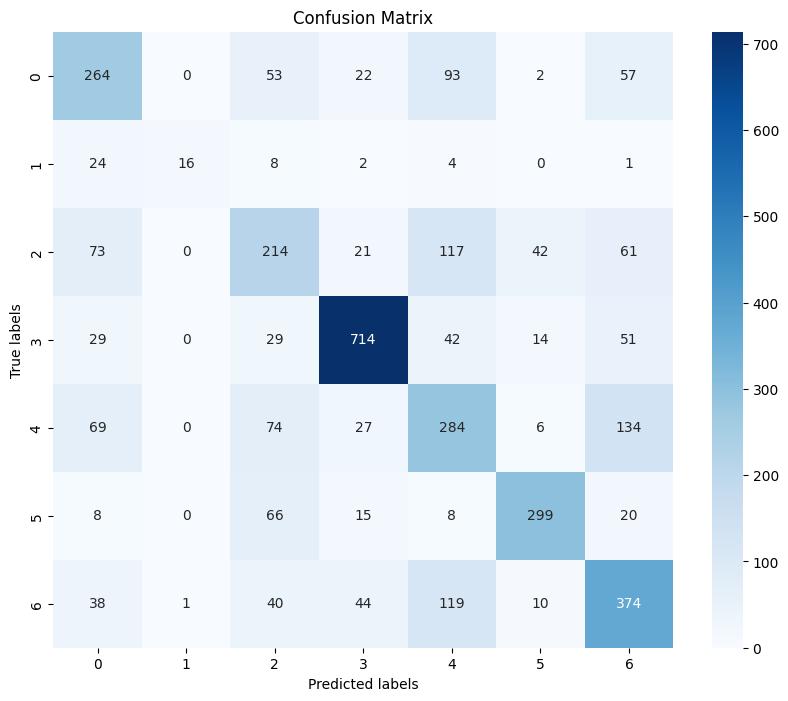

In [74]:
# take the best model for evaluation
fer_pred_y = best_model.predict(fer_test_reshape_X)
fer_pred_y = np.argmax(fer_pred_y, axis=1)
eval(fer_pred_y, fer_test_Y, [0,1,2,3,4,5,6])

In [78]:
# save the model for further using
best_model.save('./fer2013_cnn.keras')

## 3.2 fer2013 Trained CNN for Phoebe Inference
+ **unmatching image size:** The only thing that needs to pay attention to is that Phoebe dataset contains images with different sizes, which does not fit our trained CNN in last section. Thus here I need to resize phoebe images to (48\*48\*1) images and reshape them.
+ **unmatching label sets**: Another thing that needs to be noticed here is the label set of these two dataset is different, but since Phoebe dataset label set is a subset of fer2013 dataset, it is okay to directly use the fer2013-NN model for inference. Though there may be some data be predicted as "neutural" or "fear", which does not appear in the Phoebe dataset, which does not make sense.
---
+ **result analysis**:

In [25]:
# reload the best model from keras tuner
best_model = keras.models.load_model('./fer2013_cnn.keras')

In [26]:
# load gray-scale phoebe images
pb_fn = []
pb_gs_imgs = []
for k, v in img_dic.items():
  color_image = cv2.imread(v)
  # Convert the color image to grayscale
  gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
  # Resize with interpolation
  gray_image = cv2.resize(gray_image, (48, 48), interpolation = cv2.INTER_CUBIC)
  # normalize to [0,1]
  pb_gs_imgs.append((gray_image/256))
  pb_fn.append(k)

# add gray scale image data to dataframe
pb_gs_df = pd.DataFrame({'file_name': pb_fn, 'gs_img': pb_gs_imgs})
# left join
phoebe_df = pd.merge(phoebe_df, pb_gs_df, on='file_name', how='left')

# extract known and unknown images
pb_known_df = phoebe_df[phoebe_df['label'] != 'unknown']
pb_unknown_df = phoebe_df[phoebe_df['label'] == 'unknown']

In [27]:
# construct Phoebe gray scale image train and test datasets
pb_train_X = pb_known_df[['gs_img']]
pb_train_Y = pb_known_df['label']

pb_test_X = pb_unknown_df[['gs_img']]
pb_test_Y = pd.DataFrame({'label' : ['angry', 'angry', 'sad', 'happy', 'surprise', 'angry', 'surprise', 'happy', 'sad', 'happy', 'disgust', 'surprise']})

In [28]:
# convert the input data shape
def my_flatten(col):
  return (np.array(col).reshape(-1))

pb_train_X['gs_img'] = pb_train_X['gs_img'].apply(my_flatten)
pb_test_X['gs_img'] = pb_test_X['gs_img'].apply(my_flatten)

def split(row):
  return pd.Series(row['gs_img'])

pb_train_reshape1_X = pb_train_X.apply(split, axis=1)
pb_test_reshape1_X = pb_test_X.apply(split, axis=1)

pb_train_reshape_X = pb_train_reshape1_X.values.reshape(-1, 48, 48, 1)
pb_test_reshape_X = pb_test_reshape1_X.values.reshape(-1, 48, 48, 1)

<ipython-input-28-81d77f09504c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pb_train_X['gs_img'] = pb_train_X['gs_img'].apply(my_flatten)
<ipython-input-28-81d77f09504c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pb_test_X['gs_img'] = pb_test_X['gs_img'].apply(my_flatten)


In [31]:
# map phoebe label to fer label
# recall that phoebe dataset only has 5 emotions(without fear and neutral)
fer_to_pb_dic = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6: 'neutral'
}

pb_to_fer_dic = {k:v for v, k in fer_to_pb_dic.items()}
fer_label_list = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

1/1 [==============================] - 0s 18ms/step
Accuracy: 0.08
F-score: 0.07
Precision: 0.06
Recall: 0.08


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


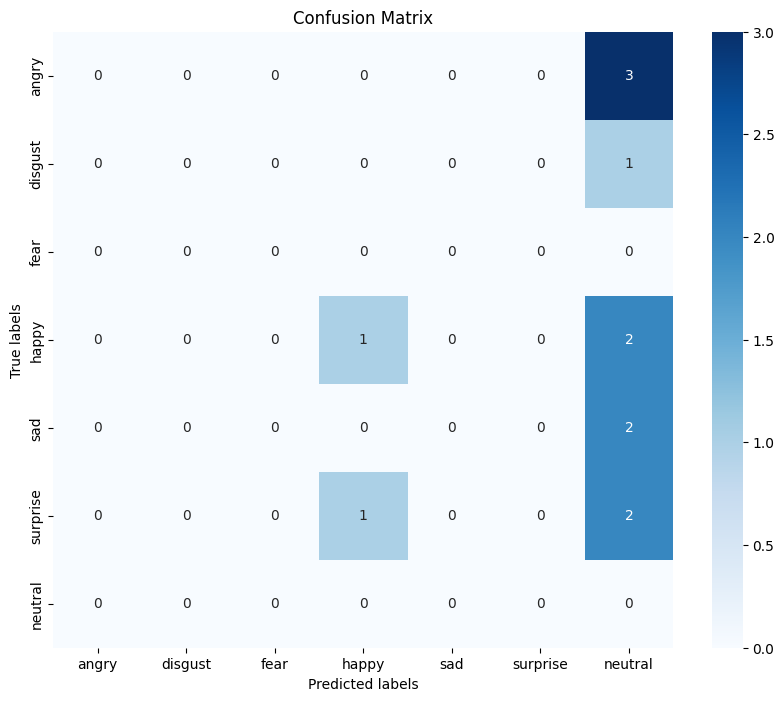

In [35]:
# inference on phoebe unknown dataset
pb_pred_y = best_model.predict(pb_test_reshape_X)
pb_pred_y = np.argmax(pb_pred_y, axis=1)
# convert labels
pb_pred_y = [fer_to_pb_dic[l] for l in pb_pred_y]
pb_train_Y = [pb_to_fer_dic[l] for l in pb_train_Y]
eval(pb_pred_y, pb_test_Y, fer_label_list)

## 3.3 fer2013-NN Finetune on Phoebe
+ **trainable layer design**: Since both dataset is used to classify facial emotions, then the convolutional layers should extract implicit features realted to the task, these features should be thus I decide to freeze all convolutional blocks and only finetune the last dense layer related to the classification task.
---
+ **result analysis**: After finetuning, the performance on test set is significantly increased compared to the un-tuned one in 3.2. This means model has good generalization ability even when seeing new face, and when the image is distorted.

In [141]:
# reload the best model from keras tuner
best_model = keras.models.load_model('./fer2013_cnn.keras')

In [142]:
# freeze all three convolutional layers
for layer in best_model.layers[:-3]:
  layer.trainable = False

for layer in best_model.layers[-3:]:
  layer.trainable = True

best_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [143]:
# convert label from list to numpy array
pb_train_Y = np.array(pb_train_Y)
# split 1/5 as validation set for finetuning (in case of overfiting)
pb_train_reshape_X1, pb_val_reshape_X, pb_train_Y1, pb_val_Y = train_test_split(pb_train_reshape_X, pb_train_Y, test_size=0.1, stratify=pb_train_Y, random_state=42)

In [144]:
# finetune model
best_model.fit(pb_train_reshape_X1,
        pb_train_Y1,
        epochs=20,
			  validation_data=(pb_val_reshape_X, pb_val_Y),
        callbacks=[callbacks.EarlyStopping('val_loss', patience=5)])

Epoch 1/20
3/3 [==============================] - 2s 188ms/step - loss: 3.2611 - accuracy: 0.2987 - val_loss: 1.1629 - val_accuracy: 0.6667
Epoch 2/20
3/3 [==============================] - 0s 37ms/step - loss: 2.5493 - accuracy: 0.3896 - val_loss: 1.2420 - val_accuracy: 0.5556
Epoch 3/20
3/3 [==============================] - 0s 30ms/step - loss: 1.4365 - accuracy: 0.5455 - val_loss: 1.5484 - val_accuracy: 0.3333
Epoch 4/20
3/3 [==============================] - 0s 37ms/step - loss: 1.7165 - accuracy: 0.5195 - val_loss: 1.3751 - val_accuracy: 0.4444
Epoch 5/20
3/3 [==============================] - 0s 34ms/step - loss: 1.0996 - accuracy: 0.6753 - val_loss: 0.9626 - val_accuracy: 0.6667
Epoch 6/20
3/3 [==============================] - 0s 34ms/step - loss: 0.7899 - accuracy: 0.7922 - val_loss: 0.8831 - val_accuracy: 0.6667
Epoch 7/20
3/3 [==============================] - 0s 38ms/step - loss: 0.8412 - accuracy: 0.6623 - val_loss: 0.9440 - val_accuracy: 0.7778
Epoch 8/20
3/3 [==========

1/1 [==============================] - 0s 124ms/step
Accuracy: 0.67
F-score: 0.70
Precision: 0.70
Recall: 0.75


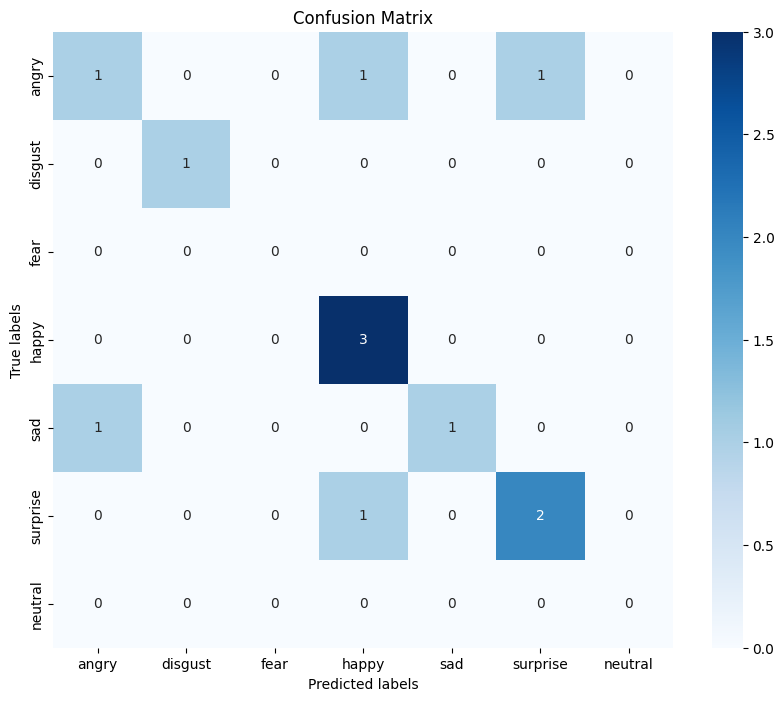

In [145]:
# use fintuend model for inference
pb_pred_y = best_model.predict(pb_test_reshape_X)
pb_pred_y = np.argmax(pb_pred_y, axis=1)
# convert labels
pb_pred_y = [fer_to_pb_dic[l] for l in pb_pred_y]
eval(pb_pred_y, pb_test_Y, fer_label_list)

In [146]:
# store the fintuned model
best_model.save('./fer2013_cnn_phebe_fintuned.keras')

# 4. Part C - omparison between Methods
|Model|Accuracy|F1-Score|Precision|Recall|
|---|---|---|---|---|
|SVM-Fer2013|0.25|0.07|0.17|0.05|
|SVM-OpenFace|0.58|0.46|0.50|0.45|
|NN-Fer2013|0.08|0.07|0.06|0.08|
|NN-FineTuned|0.67|0.70|0.70|0.75|

Table above shows 4 models' facial emotion recoginition classification peformance on the phoebe dataset. Below are some observation and conclusion I draw:
1. **best performing model**: NN-FineTuned model has the best performance out of these 4 types of the model. The main reason is the **size of the phoebe dataset is small**. Though the handcraft action unit features are strong supporting features for emotion recognition, SVM is only trained on less than 100 images. However the CNN model is first trained on fer2013, which contains 28,709 images. With sufficient amount of pretraining data and fintuning, CNN is bound to learn more data pattern than SVM. The second reason may related to features used in these two models are different.
2. **handcraft feature vs. NN extracted feature**: By comparing the result of the SVM-OpenFace model and the NN-FineTuned model result, we find that NN-FineTuned has 9% increase in accuracy and 24% in F1 score than SVM-OpenFace model, this is a significant improvement. This implies that for facial emotion recognition task, useing NN-extracted features provides more implicit information about different emotions, which further helps model to make good predictions.
3. **limitation of NN**: Though in this task NN has the best performance, here are some limitations of NN that we cannot ignore: (1) **computing resource required**: Usually the training of CNN model requires GPU resource, otherwise the training time is unberably long. However SVM is faster to train. (2) **amount of data required**: Considering the parameter size of the CNN model(in my design is 4359367 parameters), a sufficient amount of training data is required to train it, otherwise the network will severly overfit. This is the main reason we need to do a pretraining using the fer2013 dataset, and then finetune it on the phoebe dataset. However, in the real-world cases, such large amount of data may not be accessible. But SVM works well even when we only have a small amount of data. (3) **label space unmatching**: This is a another question raised when a pretraining is needed. Usually two different dataset will have different types of label, so when pretraining on one of the dataset, NN model learns to extract useful features according to a set of target labels. But when finetuning it on another dataset, previous feature extracted may not work well on another set of target labels. Sometimes an additional model rearchitection is needed. (Luckily in this task, pheobe label set is a subset of fer2013 label set, which makes the finetuning simpler.) (4) **low transparency**: Though the automatic feature extraction done by the CNN model is carefree, the drawback is also clear, that is the feature extracted is hard to understand by huaman. This low transparency of how NN model makes its prediction makes it hard for humans to learn from it, and also creates barriers to tune it when perfromance is not good. SVM, however provides clear decision plane with clear definition of its meaning.


In [148]:
# retrian a model using the best set of hyperparameters in PartA 2.1
fer2013_svm = SVC(C=1, kernel='rbf')
fer2013_svm.fit(fer_train_X, fer_train_Y)

SVC(C=1)

In [152]:
from joblib import dump, load
dump(fer2013_svm, './fer2013_svm.joblib')

['./fer2013_svm.joblib']

Accuracy: 0.25
F-score: 0.07
Precision: 0.17
Recall: 0.05


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


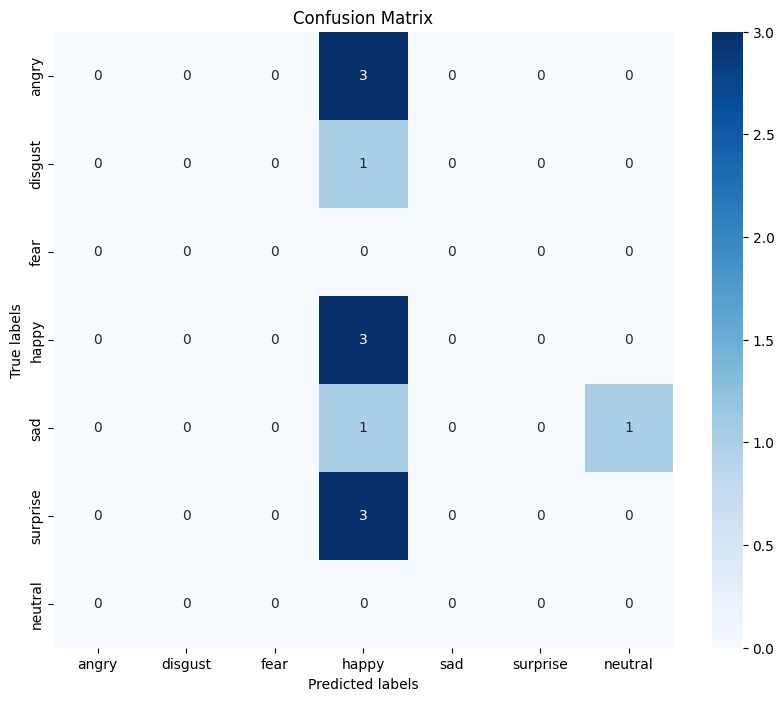

In [176]:
# use fer2013 pixcel model to perform inference on phoebe unknown dataset
pb_pred_y = fer2013_svm.predict(pb_test_reshape1_X)
pb_pred_y = [fer_to_pb_dic[l] for l in pb_pred_y]
eval(pb_pred_y, pb_test_Y, fer_label_list)